In [1]:
import os
dirpath = os.getcwd()
path=dirpath + '/data_samples/img-060705-17.10.14-p-018t000.jpg'

import numpy as np
import matplotlib.pyplot as plt
import cv2

'''import os
os.listdir()'''

class Scene:
    # Class stores image pixels paired with depth values of ambiguous scale.
    def __init__(self, img, mapmat):
        self.chans = (img, __improve(mapmat))
        return self
    
    def __improve(mapmat):
    # Requires subclass implementation per dataset, result should be double distance values from 0 to 1
        return mapmat

In [2]:
from scipy.io import loadmat
x = loadmat(dirpath + '/data_samples/depth_sph_corr-060705-17.10.14-p-018t000.mat')
positions = x['Position3DGrid']

(mapH, mapW, x) = positions.shape
result = np.zeros((mapH,mapW))
for i in range(0, mapH):
    for j in range(0, mapW):
        result[i][j] = positions[i][j][3]
cv2.imwrite('map_initial.jpg',result)
img = cv2.imread(path)
map_ = cv2.resize(result, dsize=(img.shape[1], img.shape[0]), interpolation=cv2.INTER_CUBIC)
plt.imshow(map_)
cv2.normalize(map_,map_,0,1,cv2.NORM_MINMAX)
plt.ylabel('Depth Map (map_)')
plt.show()

NameError: name 'dirpath' is not defined

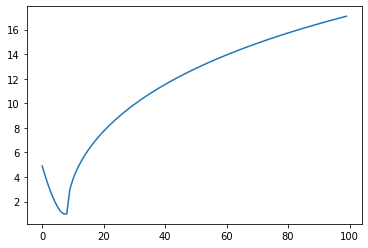

In [3]:
def make_disc_kernel(radius):
    '''
    Function produces a flat disc filter,
    Meant to mimic camera Bokeh
    '''
    rounded = int(radius)
    x = np.arange(-rounded, rounded - 1)
    y = np.arange(-rounded, rounded - 1)
    xx, yy = np.meshgrid(x, y, sparse=True)
    disc = np.ones((rounded*2-1,rounded*2-1))
    disc[(xx+1)**2+(yy+1)**2 > (.9*radius)**2] = .5
    disc[(xx+1)**2+(yy+1)**2 > (1.0*radius)**2] = 0
    return disc/np.sum(disc)
"""
def gamma_corrector(img, gamma):
    '''
    Function takes image and applies
    gamma
    '''
    img = img/255.0
    img = np.power(img, gamma)
    img = img*255
    return img.astype(np.uint8)
    """
def make_blur_LUT(focus_plane = .3, falloff = .1):
    '''
    Returns a LUT spanning ambiguous distance
    of 0 to 1
    '''
    roll = np.arange(focus_plane, 1, .01)
    front = np.arange(0, focus_plane, .01)
    roll = np.log(roll+(1-focus_plane))**.5
    front = 10*np.flip(np.exp(front)-1)**1.5
    dist = (20*np.concatenate((front,roll)))+1
    return dist

plt.plot(make_blur_LUT(.08))
plt.show()

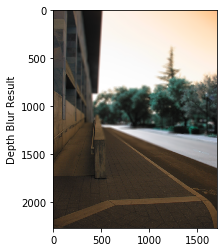

True

In [4]:
def depth_based_blur(layer, map_, skip = 10):
    '''
    Blurs a single image based on a  depth map of equal dimentions
    and creates 100/skip different blur thresholds.
    '''
    thresh = 0
    layer_old = np.zeros(img.shape)
    dist = make_blur_LUT(.08)
    dist = dist[0:-1:skip]
    for num, blur_degree in enumerate(dist):
        threshold_indices = map_ <= thresh
        mask_mat = np.zeros(img.shape)
        mask_mat[threshold_indices] = 1
        bokeh_kernel = make_disc_kernel(blur_degree)
        layer = cv2.filter2D(img, 8, bokeh_kernel)
        '''
        img_gam = gamma_corrector(img,4)
            # Gamma step increases bokeh in highlights, emulating real photos
        gamma_layer = cv2.filter2D(img_gam, 8, bokeh_kernel)
        layer[layer < gamma_layer] = gamma_layer[layer < gamma_layer]
            # Takes high gamma bokeh while keeping original gamma for majority of the image
            '''
        layer[np.nonzero(mask_mat)] = layer_old[np.nonzero(mask_mat)]
        layer_old = np.copy(layer)
        thresh += 1.0/(100/skip)
    return layer

layer = depth_based_blur(img, map_)

plt.imshow(layer)
plt.ylabel('Depth Blur Result')
plt.show()
cv2.imwrite('dist_blur_test.jpeg', layer)